In [1]:
using DataFrames
using JuMP, Cbc, Xpress

┌ Info: Xpress: Found license file xpauth.xpr
└ @ Xpress C:\Users\lucasresck\.julia\packages\Xpress\Jdi4R\src\xprs_userlic.jl:43
┌ Info: Xpress: User license detected.
└ @ Xpress C:\Users\lucasresck\.julia\packages\Xpress\Jdi4R\src\xprs_userlic.jl:98
┌ Info: Xpress-MP licensed by Fair Isaac Corporation to PSR for PSR applications
└ @ Xpress C:\Users\lucasresck\.julia\packages\Xpress\Jdi4R\src\xprs_userlic.jl:99


In [2]:
include("..\\..\\Functions\\dados_e_plot.jl");

In [3]:
#Valores padrão
G = [10, 5, 20, 18, 23, 32, 7, 12, 10, 20, 17, 32, 12, 13, 17]
d = [238, 220, 187, 175, 135, 127, 144, 165, 193, 205, 213, 233]
R = [33, 46, 32, 27, 10, 8, 20, 21, 37, 41, 27, 27]
θ = 0.2
Ns = 10
K = Int.(ones(length(G)))
cg = Int.(zeros(length(G)))

d_array = [[Int(round(d * 0.7)) for d in d]]
for scenario in 2:Ns
    push!(d_array, [Int(round(d * (0.4 + 0.6 * rand()))) for d in d])
end
dsR = hcat(d_array...);

# 1.8 Probabilidade de falha

## 1.8.1 Soma de variáveis aleatórias

Dadas duas variáveis independentes $X$ e $Y$ e suas probabilidades $f_X(x)$ e $f_Y(y)$, respectivamente, como calcular $f_Z(z)$ onde $Z = X + Y$?

Calculamos a probabilidade conjunta $f(x, y) = f_X(x)f_Y(y)$.

Seguimos com $F_Z(z) = P(Z \leq z) = P(X + Y \leq z) = \int\int_{R}f(x, y)dA$, com $R$ definida pela região $X + Y \leq z$. Temos, portanto, a probabilidade acumulada de $X + Y \leq z$.

Temos também $F_Z(z) = \int_{-\infty}^z f_Z(t)dt$. Deriva-se $F_Z(z)$ encontrado e tem-se $f_Z(z)$.

## 1.8.2 Implementação para $2$ usinas

Uma implementação possível para duas usinas é calcular a priori as probabilidades para todos os casos de manutenção. 

$f_i$ é uma variável auxiliar que indica que a usina $i$ está em manutenção ($0$ corresponde à manutenção); $P_c$ é a probabilidade da demanda ser suprida em um dado cenário de manutenção; $P_j$ é a probabilidade da demanda ser suprida no cenário de manutenção $j$; $\gamma_j$ é uma variável auxiliar da convolução. Segue:

$$min\ \ G_{disp}$$

$$s.a.\ \ G_{disp} = \sum G_i f_i$$
$$P_c \geq \epsilon$$
$$P_c = \sum_{j = 0} P_j \gamma_j$$
$$\sum_{j = 0} \gamma_j = 1$$

$$\gamma_j \geq 0, \forall j$$
$$\gamma_0 \geq 1 - f_1 - f_2$$
$$\gamma_1 \geq f_1 - f_2$$
$$\gamma_2 \geq f_2 - f_1$$
$$\gamma_3 \geq f_1 + f_2 - 1$$

Sendo assim, como $\sum_{j = 0} \gamma_j = 1$, apenas um $\gamma_j$ será $1$, de modo que $P_c = \sum_{i = 0} P_i \gamma_i$ será igual a apenas um $P_j \gamma_j$. Ou seja, o solver escolhe aquele caso (ou um daqueles casos) em que $P_j \geq \epsilon$.

Sejam duas usinas com capacidades disponíveis $G_1 = 30$ e $G_2 = 40$ e uma demanda $D = 35$.

In [4]:
G8_2 = [30, 40]
D8_2 = 35
p8_2 = [0.5, 0.5]
ϵ8_2 = 0.3 #Probabilidade de falha de cada gerador
nplants8_2 = length(G8_2)
nmonths8_2 = size(D8_2);

In [5]:
tabela8_2 = DataFrames.DataFrame(usinas = [0, 1, 2, [1,2]], probabilidade = [0, 0, 0.5, missing])

,usinas,probabilidade
,Any,Float64⍰
1,0,0.0
2,1,0.0
3,2,0.5
4,"[1, 2]",missing


In [6]:
F_Z8_2 = 0
for X in [0, 1]
    for Y in [0, 1]
        Z = G8_2[1] * X + G8_2[2] * Y
        if Z < D8_2
            F_Z8_2 += (X + (-1)^X * p8_2[1]) * (Y + (-1)^Y * p8_2[2])
        end
    end
end
tabela8_2.probabilidade[4] = 1 - F_Z8_2
tabela8_2

,usinas,probabilidade
,Any,Float64⍰
1,0,0.0
2,1,0.0
3,2,0.5
4,"[1, 2]",0.5


In [7]:
m8_2 = Model(solver = Xpress.XpressSolver())

@variable(m8_2, f[1:nplants8_2], Bin)
@variable(m8_2, γ[1:nplants8_2^2], Bin)
@variable(m8_2, G_disp)
@variable(m8_2, Pc)

@constraint(m8_2, G_disp == sum(G8_2 .* f))
@constraint(m8_2, Pc >= ϵ8_2)
@constraint(m8_2, Pc == sum(tabela8_2.probabilidade .* γ))
@constraint(m8_2, sum(γ) == 1)

@constraint(m8_2, γ[1] >= 1 - f[1] - f[2])
@constraint(m8_2, γ[2] >= f[1] - f[2])
@constraint(m8_2, γ[3] >= f[2] - f[1])
@constraint(m8_2, γ[4] >= f[1] + f[2] - 1)

@objective(m8_2, Min, G_disp);

In [8]:
@time solve(m8_2)
@show getvalue(f)
@show getvalue(γ)
@show getvalue(G_disp)
@show getvalue(Pc);

  4.969439 seconds (10.78 M allocations: 526.583 MiB, 5.83% gc time)
getvalue(f) = [-0.0, 1.0]
getvalue(γ) = [-0.0, -0.0, 1.0, -0.0]
getvalue(G_disp) = 40.0
getvalue(Pc) = 0.5


## 1.8.3 Implementação para $n$ usinas

Calcula-se a priori as probabilidades para todos os casos de manutenção. 

$f_i$ é uma variável auxiliar que indica que a usina $i$ está em manutenção ($0$ corresponde à manutenção); $P_c$ é a probabilidade da demanda ser suprida em um dado cenário de manutenção; $P_j$ é a probabilidade da demanda ser suprida no cenário de manutenção $j$; $\gamma_j$ é uma variável auxiliar para o cálculo. Segue:

$$min\ \ G_{disp}$$

$$s.a.\ \ G_{disp} = \sum G_i f_i$$
$$P_c \geq \epsilon$$
$$P_c = \sum_{j = 0} P_j \gamma_j$$
$$\sum_{j = 0} \gamma_j = 1$$

$$\gamma_j \geq 0, \forall j$$
$$\gamma_j \geq \sum_{k \in K_j} f_k - \sum_{m \in M_j} f_m - |K_j| + 1, \ \ \forall j$$

sendo $K_j$ o conjunto de usinas disponíveis no cenário de manutenção $j$, $M_j$ o conjunto de usinas em manutenção no cenário $j$ e $|K_j|$ o número de usinas disponíveis no cenário $j$.

In [9]:
G8_3 = G
D8_3 = 180
ϵ8_3 = 0.5
p8_3 = rand(0:2, 15) ./ 10
nplants8_3 = length(G8_3);

In [10]:
function prob(G, p, D)
    F_Z = 0
    nplants = length(G)
    for config in 0:(2^nplants - 1) #Para cada configuração de falha
        config_bin = Base.bin(Unsigned(config), nplants, false) #Converte para binário
        X = [parse(Int, config_bin[end - plant + 1]) for plant in 1:nplants] #Converte para array
        Z = sum(G .* X)            
        if Z < D
            F_Z += prod(X .+ (-1).^X .* p)
        end
    end
    return 1 - F_Z
end;

In [11]:
function tabela(G, p, D)
    nplants = length(G)
    tabela = zeros(2^nplants, 2)
    tabela = convert(Array{Any}, tabela)
    
    for config in 0:(2^nplants - 1)
        config_bin = Base.bin(Unsigned(config), nplants, false)
        X = [parse(Int, config_bin[end - plant + 1]) for plant in 1:nplants] #Converte para array
        Z = sum(G .* X)
        if Z >= D
            tabela[config + 1, 1] = config_bin
            G_aux = []
            p_aux = []
            for plant in 1:nplants
                if config_bin[end + 1 - plant] == '1'
                    push!(G_aux, G[plant])
                    push!(p_aux, p[plant])
                end
            end
            if length(G_aux) == 0 #Se o número de usinas é zero
                probability = 0.0
            else
                probability = prob(G_aux, p_aux, D)
            end
            tabela[config + 1, 2] = probability
        end
    end
    return tabela
end;     

In [12]:
@time tabela8_3 = tabela(G8_3, p8_3, D8_3);

 17.766970 seconds (239.70 M allocations: 7.109 GiB, 9.37% gc time)


In [13]:
m8_3 = Model(solver = Xpress.XpressSolver(OUTPUTLOG = 1))

@variable(m8_3, G_disp)
@variable(m8_3, f[1:nplants8_3], Bin)
@variable(m8_3, Pc)
@variable(m8_3, γ[1:2^nplants8_3], Bin)

@constraint(m8_3, G_disp == sum(G8_3 .* f))
@constraint(m8_3, Pc >= ϵ8_3)
@constraint(m8_3, Pc == sum(tabela8_3[:, 2] .* γ))
@constraint(m8_3, sum(γ) == 1)

for j in 0:(2^nplants8_3 - 1)
    j_bin = Base.bin(Unsigned(j), nplants8_3, false)
    j_array = [parse(Int, j_bin[end + 1 - plant]) for plant in 1:nplants8_3]
    @constraint(m8_3, γ[j + 1] >= sum((-1)^(1 + j_array[plant]) * f[plant] for plant in 1:nplants8_3) + 1 - count_ones(j))
end

@objective(m8_3, Min, G_disp);

In [14]:
JuMP.build(m8_3)
Xpress.setlogfile(m8_3.internalModel.inner,"D:/m8_3.log")

In [15]:
@time solve(m8_3)
@show getvalue(f)
#@show getvalue(γ)
@show getvalue(G_disp)
@show getvalue(Pc);

144.829841 seconds (133 allocations: 6.542 MiB, 0.01% gc time)
getvalue(f) = [1.0, -0.0, 1.0, 1.0, 1.0, 1.0, -0.0, 1.0, -0.0, 1.0, -0.0, 1.0, -0.0, 1.0, -0.0]
getvalue(G_disp) = 180.0
getvalue(Pc) = 0.5183999999999999


## 1.8.4 Método de Monte Carlo

O cálculo da probabilidade utilizando o Método de Monte Carlo consiste em simular repetidamente o processo aleatório de falha das usinas, utilizando suas probabilidades de falha, e verificar se a demanda é suprida em cada caso. A probabilidade da demanda ser suprida é aproximadamente a razão entre o número de casos em que a demanda foi suprida na simulação e o número total de casos.

In [16]:
G8_4 = G8_2
p8_4 = p8_2
D8_4 = D8_2;

In [17]:
function prob_MC(G, p, D, n)
    nplants = length(G)
    count = 0
    for i in 1:n
        Z = 0
        for plant in 1:nplants
            if rand() > p[plant]
                Z += G[plant]
            end
        end
        if Z >= D
            count += 1
        end
    end
    return count / n
end;

In [18]:
function tabela_MC(G, p, D; n = 1000)
    nplants = length(G)
    tabela = zeros(2^nplants, 2)
    tabela = convert(Array{Any}, tabela)
    
    for config in 0:(2^nplants - 1)
        config_bin = Base.bin(Unsigned(config), nplants, false)
        tabela[config + 1, 1] = config_bin
        G_aux = []
        p_aux = []
        for plant in 1:nplants
            if config_bin[end + 1 - plant] == '1'
                push!(G_aux, G[plant])
                push!(p_aux, p[plant])
            end
        end
        if length(G_aux) == 0 #Se o número de usinas é zero
            probability = 0.0
        else
            probability = prob_MC(G_aux, p_aux, D, n)
        end
        tabela[config + 1, 2] = probability
    end
    return tabela
end;     

In [19]:
tabela8_4 = tabela_MC(G8_4, p8_4, D8_4, n = 10000)

4×2 Array{Any,2}:
 "00"  0.0   
 "01"  0.0   
 "10"  0.4969
 "11"  0.4982

In [20]:
G8_4_2 = G8_3
p8_4_2 = p8_3
D8_4_2 = D8_3;

In [21]:
@time tabela8_4_2 = tabela_MC(G8_4_2, p8_4_2, D8_4_2);

 11.953352 seconds (246.38 M allocations: 3.686 GiB, 8.16% gc time)


In [22]:
tabela8_3[(end - 10):end, :]

11×2 Array{Any,2}:
 "111111111110101"  0.895997
 "111111111110110"  0.863214
 "111111111110111"  0.930185
 "111111111111000"  0.737787
 "111111111111001"  0.834002
 "111111111111010"  0.793587
 "111111111111011"  0.859906
 "111111111111100"  0.924739
 "111111111111101"  0.960975
 "111111111111110"  0.943718
 "111111111111111"  0.973848

In [23]:
tabela8_4_2[(end - 10):end, :]

11×2 Array{Any,2}:
 "111111111110101"  0.893
 "111111111110110"  0.844
 "111111111110111"  0.925
 "111111111111000"  0.747
 "111111111111001"  0.843
 "111111111111010"  0.782
 "111111111111011"  0.864
 "111111111111100"  0.909
 "111111111111101"  0.955
 "111111111111110"  0.928
 "111111111111111"  0.976

## 1.8.5 Adição da obrigatoriedade de manutenção e vários estágios

Existem vários estágios, digamos, meses, e cada usina deve entrar em manutenção em um estágio. A probabilidade da demanda ser suprida deve ser maior do que ou igual a um parâmetro informado, para todo estágio. Maximiza-se a soma das probabilidades da demanda ser suprida nos estágios.

Calcula-se a priori as probabilidades para todos os casos de manutenção. 

$f_i^t$ é uma variável auxiliar que indica que a usina $i$ está em manutenção no estágio $t$ ($0$ corresponde à manutenção); $P_c^t$ é a probabilidade da demanda ser suprida em um dado cenário de manutenção no estágio $t$; $P_j^t$ é a probabilidade da demanda ser suprida no cenário de manutenção $j$, no estágio $t$; $\gamma_j^t$ é uma variável auxiliar para o cálculo. Segue:

$$max\ \ \sum_t P_c^t$$

$$s.a.\ \ P_c^t \geq \epsilon, \ \ \forall t$$
$$P_c^t = \sum_{j = 0} P_j \gamma_j^t, \ \ \forall t$$
$$\sum_{j = 0} \gamma_j^t = 1, \ \ \forall t$$
$$\sum_t f_i^t = |T| - 1, \ \ \forall i$$

$$\gamma_j^t \geq 0, \forall j, t$$
$$\gamma_j^t \geq \sum_{k \in K_j} f_k^t - \sum_{m \in M_j} f_m^t - |K_j| + 1, \ \ \forall j, t$$

sendo $T$ o conjunto de estágios, $|T|$ o número de estágios (exemplo, $12$ meses), $K_j$ o conjunto de usinas disponíveis no cenário de manutenção $j$, $M_j$ o conjunto de usinas em manutenção no cenário $j$ e $|K_j|$ o número de usinas disponíveis no cenário $j$.

In [44]:
G8_5 = G
d8_5 = [d[1] - 50; d[2:11]; d[12] - 50] #Esses meses têm demanda tão alta que, com os geradores, a probabilidade de suprir a demanda é muito baixa, para todos os cenários de manutenção
ϵ8_5 = 0.9
nplants8_5 = length(G8_5)
N_t8_5 = length(d8_5)
p8_5 = rand(0:5, nplants8_5) ./ 100;

In [45]:
function tabelas(G, p, d)
    N_t = length(d)
    tabelas = []
    for t in 1:N_t
        D = d[t]
        push!(tabelas, tabela(G, p, D))
    end
    return tabelas
end;

In [46]:
@time tabelas8_5 = tabelas(G8_5, p8_5, d8_5);

710.621198 seconds (3.00 G allocations: 89.791 GiB, 17.43% gc time)


In [47]:
[maximum(tabelas8_5[month][:, 2]) for month in 1:12]

12-element Array{Float64,1}:
 0.9985585387528638
 0.930634904819303 
 0.9987396282629816
 0.999782905366166 
 0.9999998634999963
 0.9999999770409224
 0.9999992569165627
 0.9999549390035044
 0.9980621656556147
 0.9895636412319883
 0.9806960798155245
 0.9995584759707943

In [48]:
tabelas8_5[1][end-10:end, 2]

11-element Array{Any,1}:
 0.9831978746030565
 0.9810601177051329
 0.9893993574978371
 0.9294740850670894
 0.9820918292145436
 0.93596794165689  
 0.9860964951513892
 0.9938048954718367
 0.9981197824041599
 0.9963803208601318
 0.9985585387528638

In [49]:
m8_5 = Model(solver = Xpress.XpressSolver(OUTPUTLOG = 1, MIPRELSTOP = 0.04, MAXTIME = 3600))

@variable(m8_5, f[1:nplants8_5, 1:N_t8_5], Bin)
@variable(m8_5, Pc[1:N_t8_5])
@variable(m8_5, γ[1:2^nplants8_5, 1:N_t8_5], Bin)

for t in 1:N_t8_5
    @constraint(m8_5, Pc[t] >= ϵ8_5)
    @constraint(m8_5, Pc[t] == sum(tabelas8_5[t][:, 2] .* γ[1:2^nplants8_5, t]))
    @constraint(m8_5, sum(γ[1:2^nplants8_5, t]) == 1)
end

for plant in 1:nplants8_5
    @constraint(m8_5, sum(f[plant, 1:N_t8_5]) == N_t8_5 - 1)
end
for t in 1:N_t8_5
    for j in 0:(2^nplants8_5 - 1)
        j_bin = Base.bin(Unsigned(j), nplants8_5, false)
        j_array = [parse(Int, j_bin[end + 1 - plant]) for plant in 1:nplants8_5]
        @constraint(m8_5, γ[j + 1, t] >= sum((-1)^(1 + j_array[plant]) * f[plant, t] for plant in 1:nplants8_5) + 1 - count_ones(j))
    end
end

@objective(m8_5, Max, sum(Pc));

In [50]:
JuMP.build(m8_5)
Xpress.setlogfile(m8_5.internalModel.inner,"D:/m8_5.log")

In [ ]:
@time solve(m8_5)
@show schedule_matrix8_5 = getvalue(f)
@show getvalue(Pc);

In [41]:
dados8_5, heatmap8_5, graph8_5 = dados_e_plot(G8_5, schedule_matrix8_5, d8_5, legend = true, inverse = true)
dados8_5

,months,plants_off,capacity_available
,Int64,Array…,Float64
1,1,[],248.0
2,2,[],248.0
3,3,[],248.0
4,4,[6],216.0
5,5,"[3, 4, 7, 9, 10, 11]",156.0
6,6,"[2, 8, 12, 14]",186.0
7,7,"[1, 13, 15]",209.0
8,8,[],248.0
9,9,[5],225.0


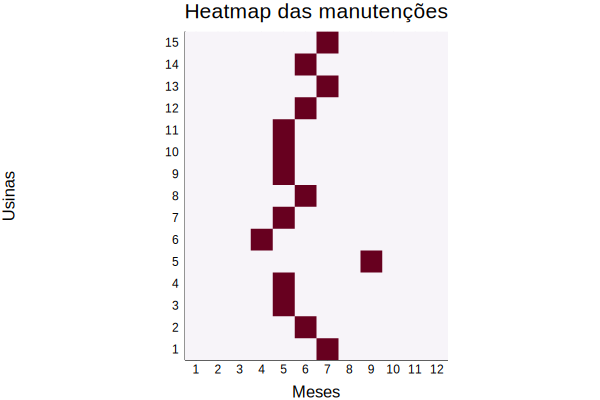

In [42]:
heatmap8_5

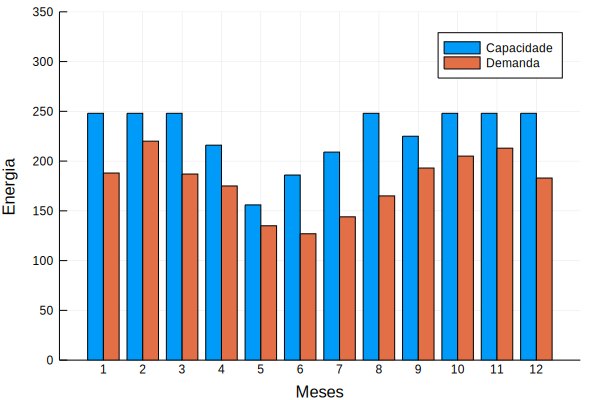

In [43]:
graph8_5